# 1. Cleaning data

### Data import

From the ``/data/Train2/files.csv`` we import all the time series recorded in the df list. Each entry of df, df[i] is a Pandas DataFrame with columns ``x, y, z, t``. 

The labels are replaced according to the three categories and stored in a list.

In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
from scipy import interpolate

# Creating list of Pandas Dataframes
df_list = []

# Read class data
data = pd.read_csv('../data/files.csv')

# Loop through each file in the Train2 directory and append the data to df_list
i = 0
for filename in os.listdir('../data/Train2'):
    df_list.append(pd.read_csv(os.path.join('../data/Train2',filename),header = None, names = ['x','y','z','time']))
    i = i + 1    

# Replace the original class labels with new labels for classification with 3 classes
labels = data['class'].replace([1,2,3,4,5,6,7,8,9,10],[1,1,1,1,1,2,2,2,3,3])

# Replace the original class labels with new labels for classification with 8 classes
# data['class'] = data['class'].replace([1,2,3,4,5,6,7,8,9,10],[1,2,3,4,5,6,6,6,7,8])

### Missing values
We verify that there are no missing values

In [2]:
# Check for missing values in each dataframe in df_list
missing_values = False
for df in df_list:
    if df.isnull().values.any():
        missing_values = True
        break

# Print a message if there are missing values
if missing_values:
    print('There are missing values in at least one dataframe')
else:
    print('There are no missing values in any dataframe')

There are no missing values in any dataframe


### Sampling time

Before moving on, we focused on the timestep. According to official documentation, the sampling frequency of the accelerometer should be the same for all registration. Many features extracted may rely and be greatly simplified by having a homogeneus timestep

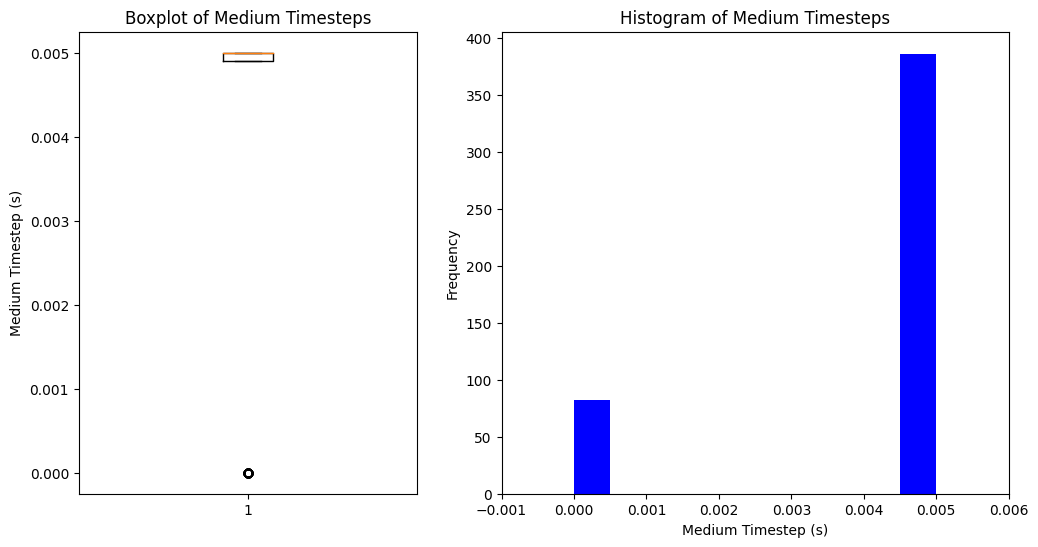

In [3]:
# Create a list to store the medium timestep for each dataframe
medium_timesteps = []

# Loop through each dataframe in df_list and calculate the medium timestep
for i, df in enumerate(df_list):
    medium_timestep = df['time'].diff().median()
    medium_timesteps.append(medium_timestep)

# Create a list to store the medium timestep for each dataframe
medium_timesteps = []

# Loop through each dataframe in df_list and calculate the medium timestep
for i, df in enumerate(df_list):
    medium_timestep = df['time'].diff().median()
    medium_timesteps.append(medium_timestep)


# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 3]})

# Create a boxplot of the medium timesteps
ax1.boxplot(medium_timesteps)
ax1.set_title('Boxplot of Medium Timesteps')
ax1.set_ylabel('Medium Timestep (s)')

# Create a histogram of the medium timesteps
ax2.hist(medium_timesteps, bins=10, color = 'blue')
ax2.set_title('Histogram of Medium Timesteps')
ax2.set_xlabel('Medium Timestep (s)')
ax2.set_ylabel('Frequency')
xticks = ax2.get_xticks()
xtick_labels = [f'{xtick:.2f}' for xtick in xticks]
ax2.set_xticks(xticks)
plt.show()

The sampling rate seems almost always coherent with what was defined on the documentation. 
There seems to be a few exceptions: in the data, time is always recorded with five digits **regardless of the number of decimal digits**.

Since starting time is not set to zeroes but varies accross observations, every observation with starting 
$\text{time} >10$ or $\text{time}>100$ will have respectively three or two digits decimal precision.

This means that some timeseries will have points recorded apparently at the same time:

In [4]:
print(df_list[np.argmin(medium_timesteps)]['time'][0:3])

0    103.47
1    103.47
2    103.48
Name: time, dtype: float64


We thus process the whole dataset using pre_process_data to shift the starting time to zero and register the correct sampling rate (200Hz) to the timeseries at fault

In [5]:
def pre_process_data(data_acc, fs):
    """
    This function interpolates the accelerometer and gyroscope data to the same time interval.

    Parameters
    ----------
    data_acc : nd-array
        Accelerometer data of specified activity
    fs : int
        Sampling frequency

    Returns
    -------
    Interpolated data (nd-array)
    """

    # Extract the time and accelerometer data from the input data
    time_acc = (data_acc.iloc[:, 3]) - data_acc.iloc[0, 3]
    data_act_acc = data_acc.iloc[:, 0:3]

    # Define the time interval for interpolation
    time_acc = np.array(time_acc)
    t0 = time_acc[0]
    tn = time_acc[-1]
    time_new = np.linspace(t0, tn, int((tn - t0) / ((1 / fs))))

    # Interpolate the accelerometer data
    data_act_acc = np.array(data_act_acc)
    acc_data = np.array([interpolate.interp1d(time_acc, data_act_acc[:, ax])(time_new) for ax in range(np.shape(data_act_acc)[1])]).T

    # Concatenate the interpolated data and the new time array
    data = np.column_stack((acc_data, time_new))
    data = pd.DataFrame(data, columns = ['x', 'y', 'z', 'time'])

    return data

def plot_data(data):
    """This function plots the accelerometer and gyroscope data.

    Parameters
    ----------
    data nd-array
    Interpolated data

    Returns
    -------
    None

    """
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs[0, 0].plot(data['time'], data['x'])
    axs[0, 0].set_title('X Acceleration')
    axs[0, 1].plot(data['time'], data['y'])
    axs[0, 1].set_title('Y Acceleration')
    axs[1, 0].plot(data['time'], data['z'])
    axs[1, 0].set_title('Z Acceleration')
    for ax in axs.flat:
        ax.set(xlabel='Time (s)', ylabel='Acceleration (m/s^2)')
    plt.show()

In [6]:
for i in range(len(df_list)):
    df_list[i] = pre_process_data(df_list[i], 200)

In [7]:
print(df_list[np.argmin(medium_timesteps)]['time'][0:3])

0    0.000000
1    0.005007
2    0.010013
Name: time, dtype: float64


# 2. Data visualization

Now that the data is cleaned, let's take a look at the dataset

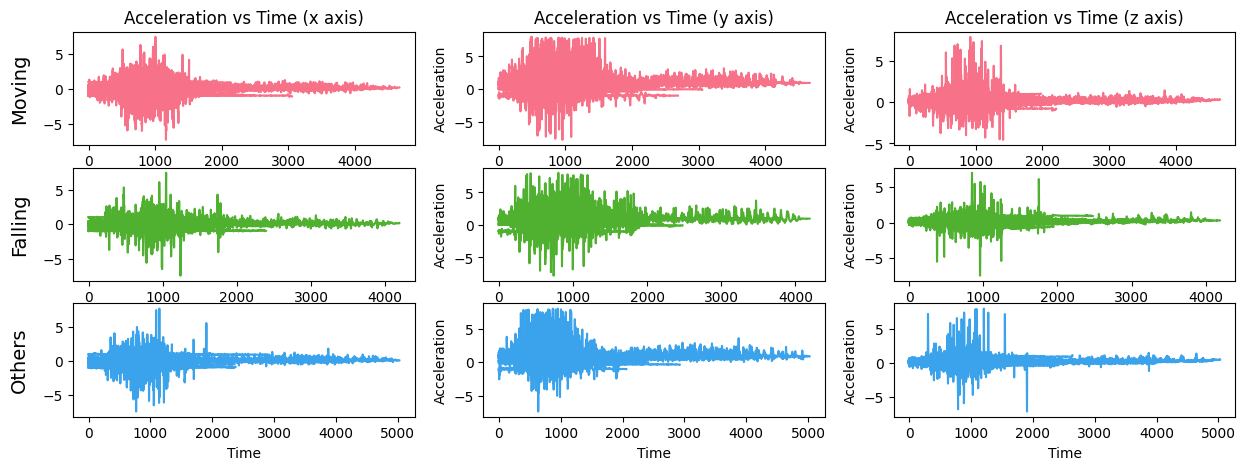

In [8]:
# Define a color palette
palette = sns.color_palette('husl', n_colors=3)

# Create a color dictionary
color_dict = dict(zip([1, 2, 3], palette))
# Create a figure with three subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 5))

# Plot the data in each subplot
for i, df in enumerate(df_list):
    for j, col in enumerate(df.columns[:-1]):
        activity_type = labels[i]
        axs[activity_type-1][j].plot(df[col], color=color_dict[labels[i]])
        axs[activity_type-1][j].set_xlabel('Time')
        axs[activity_type-1][j].set_ylabel('Acceleration')
    
        axs[0][j].set_title(f'Acceleration vs Time ({["x", "y", "z"][j]} axis)')

    axs[activity_type-1][0].set_ylabel(f'{["Moving", "Falling", "Others"][activity_type-1]}', fontsize=14, rotation=90, labelpad=10)
    axs[activity_type-1][1].set_ylabel('Acceleration')
    axs[activity_type-1][2].set_ylabel('Acceleration')

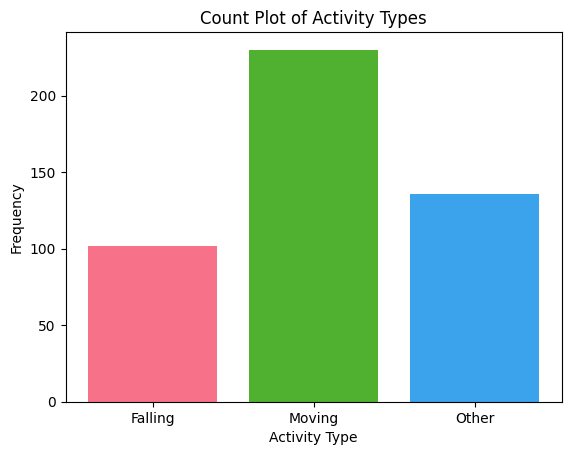

In [9]:
# Class distribution
# Calculate the unique values and their frequencies
text_labels = labels.replace([1,2,3],['Moving','Falling','Other'])
unique_values, frequencies = np.unique(text_labels, return_counts=True)

# Plotting the count plot
plt.bar(unique_values, frequencies, color = color_dict.values())
plt.xlabel('Activity Type')
plt.ylabel('Frequency')
plt.title('Count Plot of Activity Types')
plt.show()

# 3. Feature Extraction and Visualization

It's time to extract the numerical feature from our dataset to analyze it. In order to do this, we brainstormed as many relevant feature as possible to calculate that could be relevant for our problem. We identified three macro areas:

1. Basic Statistical Measures (min, max, std, ...)
2. Time Series Analysis inspired measures (turning points, zero cross count, autocorrelation, ...)
3. Signal Processing inspired measures (AUC, Peak to Peak distance, ...)

Below is the complete list, consisting of 24 features, each one extracted from each of the time series of the observation (x,y,z axis), for a total of 72 features.

The features functions and how they are calcolated are into the ``/features.py`` file. The function below calculates the feature for every observation of the df_list and append a row with the features to tsfeat.

| Statistical Measures                    | Time Series Analysis                                                                                                                                                                                                                              | Signal Processing                                       |
|-----------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------|
| Max, Min, Mean,  Median, Std,  Variance, Interquartile Range | Autocorrelation, Kurtosis,  Mean Absolute Deviation, Mean (Absolute) Difference,  Median Absolute Deviation, Median (Absolute) Difference,  Negative (Pos) Turning Points, Slope,  Sum Absolute Difference, Zero Cross Count | Area Under Curve,  Peak to Peak distance,  Total Energy |

In [10]:
# Import the Features class and the inspect module
from features import Features
import inspect

# Define a function to calculate features for each signal in a dataframe
def calc_features(df):
   
    f = Features()
    
    # Get a list of all the methods of the Features object
    attrs = (getattr(f, name) for name in dir(f))
    methods = filter(inspect.ismethod, attrs)
    
    # Create an empty dataframe to store the features
    df_features = pd.DataFrame()

    # Loop through each signal in the dataframe
    for signals in df:
        # Create empty lists to store the feature names and values
        names = []
        values = []
        
        # Loop through each column in the signal [x, y, z]
        for columns in signals.columns[:-1]: 
            # Get the signal data as a numpy array
            signal = np.array(signals[columns])
            
            # Create a Features object
            f = Features()
            attrs = (getattr(f, name) for name in dir(f))
            methods = filter(inspect.ismethod, attrs)
            
            # Loop through each method and calculate the feature value
            for method in methods:
                # Append the feature name and value to the lists
                names.append(method.__name__ + '_' + columns)
                values.append(getattr(f, method.__name__)(signal))
        
        # Create a new dataframe with the feature values and names as columns
        df_new = pd.DataFrame(values, index=names).T
        
        # Concatenate the new dataframe with the existing dataframe
        if df_features.empty:
            df_features = df_new
        else:
            df_features = pd.concat([df_features,df_new])
                
    # Return the dataframe of features
    return df_features

In [11]:
tsfeat = calc_features(df_list)
tsfeat.head()

,auc_x,autocorr_x,calc_max_x,calc_mean_x,calc_median_x,calc_min_x,calc_std_x,calc_var_x,distance_x,interq_range_x,...,median_abs_deviation_z,median_abs_diff_z,median_diff_z,negative_turning_z,pk_pk_distance_z,positive_turning_z,slope_z,sum_abs_diff_z,total_energy_z,zero_cross_z
0,2.925922,857.751508,6.273788,0.196507,0.144781,-4.450189,0.787194,0.619675,1348.753951,0.275429,...,0.120240,0.019937,-0.001021,206.0,5.191781,206.0,-0.000106,113.484574,37.331386,72.0
0,3.160421,678.096979,5.203807,0.256014,0.196345,-4.004162,0.591357,0.349703,1663.274335,0.159413,...,0.081217,0.011700,-0.000415,296.0,7.372791,295.0,0.000020,129.514980,28.410611,114.0
0,3.038086,655.118579,5.035472,0.234845,0.176271,-3.557917,0.622251,0.387197,1512.128504,0.191115,...,0.112380,0.012212,0.000391,280.0,5.606668,280.0,0.000110,105.278000,25.662942,98.0
0,2.966993,788.716277,4.104960,0.134169,0.094081,-4.326599,0.732565,0.536652,1468.569409,0.270242,...,0.132873,0.018226,-0.000609,210.0,5.179863,211.0,-0.000007,155.837385,45.661412,84.0
0,3.339751,916.547003,3.884350,0.057840,0.038862,-5.213462,0.712626,0.507835,1844.522856,0.229761,...,0.132420,0.017042,0.001022,302.0,7.162417,302.0,-0.000128,193.938233,67.691591,80.0


In [12]:
tsfeat.columns[0:24]

Index(['auc_x', 'autocorr_x', 'calc_max_x', 'calc_mean_x', 'calc_median_x',
       'calc_min_x', 'calc_std_x', 'calc_var_x', 'distance_x',
       'interq_range_x', 'kurtosis_x', 'mean_abs_deviation_x',
       'mean_abs_diff_x', 'mean_diff_x', 'median_abs_deviation_x',
       'median_abs_diff_x', 'median_diff_x', 'negative_turning_x',
       'pk_pk_distance_x', 'positive_turning_x', 'slope_x', 'sum_abs_diff_x',
       'total_energy_x', 'zero_cross_x'],
      dtype='object')

In [13]:
# Add the class labels as a new column to the tsfeat dataset
#tsfeat['class_label']=list(labels)
# Create a pairplot of the dataset
#sns.pairplot(tsfeat, hue='class_label')

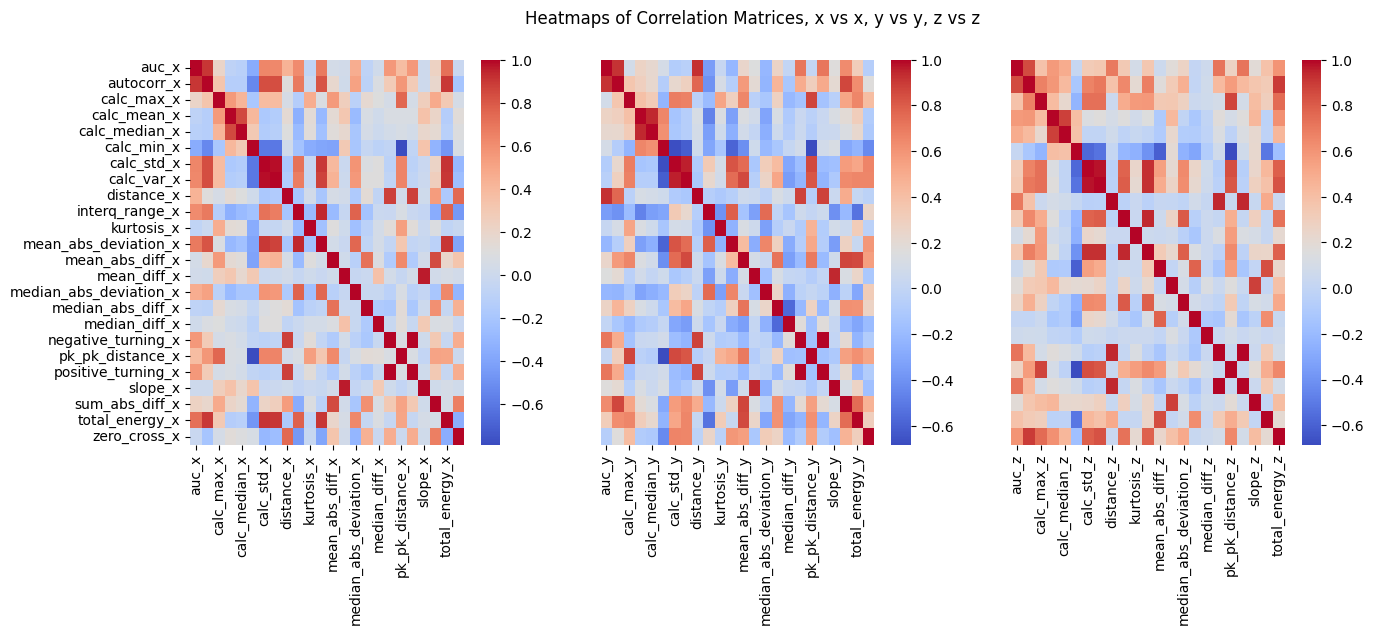

In [13]:
# Calculate the correlation matrices
corr_matrix1 = tsfeat.iloc[:, :24].corr()
corr_matrix2 = tsfeat.iloc[:, 24:48].corr()
corr_matrix3 = tsfeat.iloc[:, 48:-1].corr()

# Create a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Create a heatmap in each subplot
sns.heatmap(corr_matrix1, cmap='coolwarm',  ax=axes[0])
sns.heatmap(corr_matrix2, cmap='coolwarm',  ax=axes[1], yticklabels=False)
sns.heatmap(corr_matrix3, cmap='coolwarm',  ax=axes[2], yticklabels=False)

# Set the title of the plot
fig.suptitle('Heatmaps of Correlation Matrices, x vs x, y vs y, z vs z')

# Show the plot
plt.show()

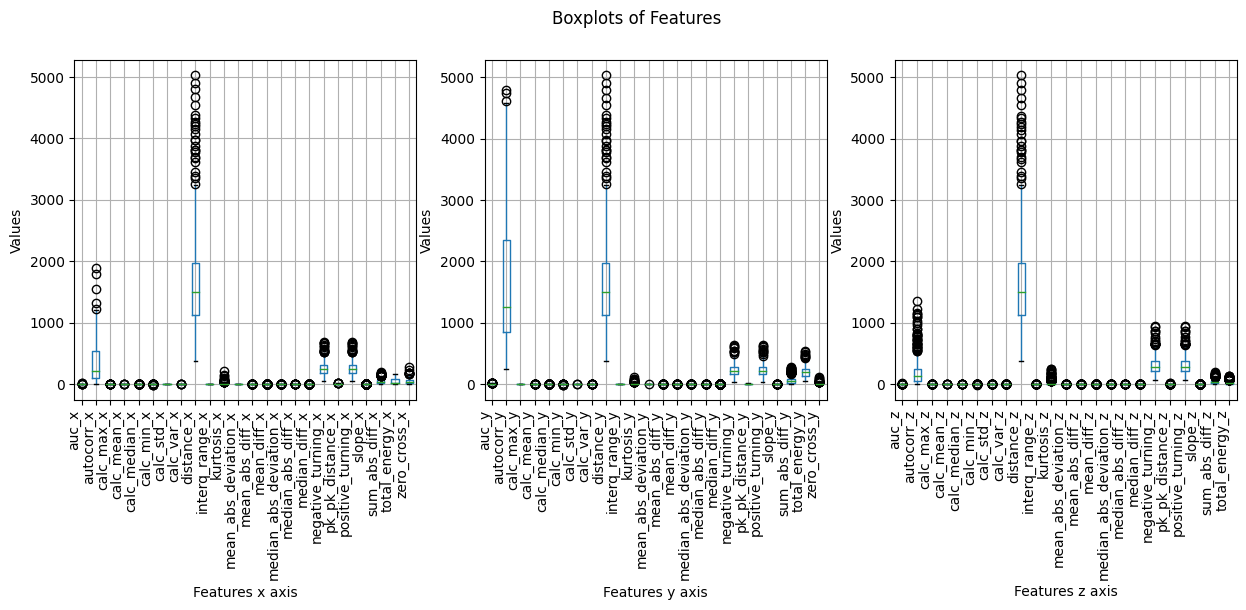

In [14]:

# Create a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Create a boxplot in each subplot
tsfeat.iloc[:, :24].boxplot(ax=axes[0])
tsfeat.iloc[:, 24:48].boxplot(ax=axes[1])
tsfeat.iloc[:, 48:-1].boxplot(ax=axes[2])

# Set the labels and title of the plot
fig.suptitle('Boxplots of Features')
axes[0].set_xlabel('Features x axis')
axes[0].set_ylabel('Values')
axes[1].set_xlabel('Features y axis')
axes[1].set_ylabel('Values')
axes[2].set_xlabel('Features z axis')
axes[2].set_ylabel('Values')
fig.autofmt_xdate(rotation=90)

# Show the plot
plt.show()

## Interactive visualization of boxplots feature vs classes, divided by axis

In [15]:
from ipywidgets import interact, IntSlider, Layout

# Define a function to create a boxplot for a given feature
def create_boxplot(feature):
    # Group the data by class label
    grouped_data = tsfeat.copy()
    grouped_data['activity'] = list(labels.replace([1,2,3],['Moving','Falling','Others']))

    # Create a grid of subplots
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    # Create a boxplot in each subplot
    grouped_data.iloc[:, :].boxplot(ax=axes[0], column = tsfeat.columns[feature], by='activity')
    grouped_data.iloc[:, :].boxplot(ax=axes[1], column = tsfeat.columns[feature+24], by='activity')
    grouped_data.iloc[:, :].boxplot(ax=axes[2], column = tsfeat.columns[feature+48], by='activity')

    # Set the labels and title of the plot
    fig.suptitle('Boxplots of Features {}'.format(tsfeat.columns[feature][:-2]))

# Create a slider to change features
slider_layout = Layout(width='50%')
feature_slider = IntSlider(min=0, max=tsfeat.shape[1]/3 -1, step=1, value=0, layout=slider_layout, description='Select Feature:', style={'description_width': 'initial', 'handle_color': 'blue'})


# Create an interactive plot
interact(create_boxplot, feature=feature_slider)

interactive(children=(IntSlider(value=0, description='Select Feature:', layout=Layout(width='50%'), max=23, st…

<function __main__.create_boxplot(feature)>

# 4. Model making

## Feature Selection

In [104]:
# Import the train_test_split module from sklearn
from sklearn.model_selection import train_test_split

# Division in Train and Test set (66%-33%)
X_train, X_test, Y_train, Y_test = train_test_split(tsfeat, labels, test_size=0.33, random_state=1999)

In [105]:
# First Feature selection
col_drop = []

# Features with high correlation for all the axis
for i in df.columns[0:3]:
    col_drop.append('autocorr_' + str(i))
    col_drop.append('calc_median_' + str(i))
    col_drop.append('calc_var_' + str(i))
    col_drop.append('total_energy_' + str(i))
    col_drop.append('mean_diff_' + str(i))
    col_drop.append('positive_turning_' + str(i))
    col_drop.append('negative_turning_' + str(i))
    col_drop.append('mean_abs_deviation_' + str(i))
    col_drop.append('pk_pk_distance_' + str(i))
    col_drop.append('sum_abs_diff_' + str(i))

# Features with high correlation for the y axis
col_drop.append('auc_y')

# Features with high correlation for the z axis
col_drop.append('calc_std_z')

# Features with high correlation between the x and y axis
col_drop.append('distance_y')
col_drop.append('mean_abs_diff_y')
col_drop.append('median_abs_diff_y')

# Features with high correlation between the x and z axis
col_drop.append('distance_z')
col_drop.append('mean_abs_diff_z')

# Features with high correlation between the y and z axis
col_drop.append('median_abs_deviation_z')
col_drop.append('median_abs_diff_z')

# Drop the features from the train and test set
X_train = X_train.drop(col_drop, axis=1)
X_test = X_test.drop(col_drop, axis=1)

In [106]:
# Number of features left
X_train.shape

(313, 33)

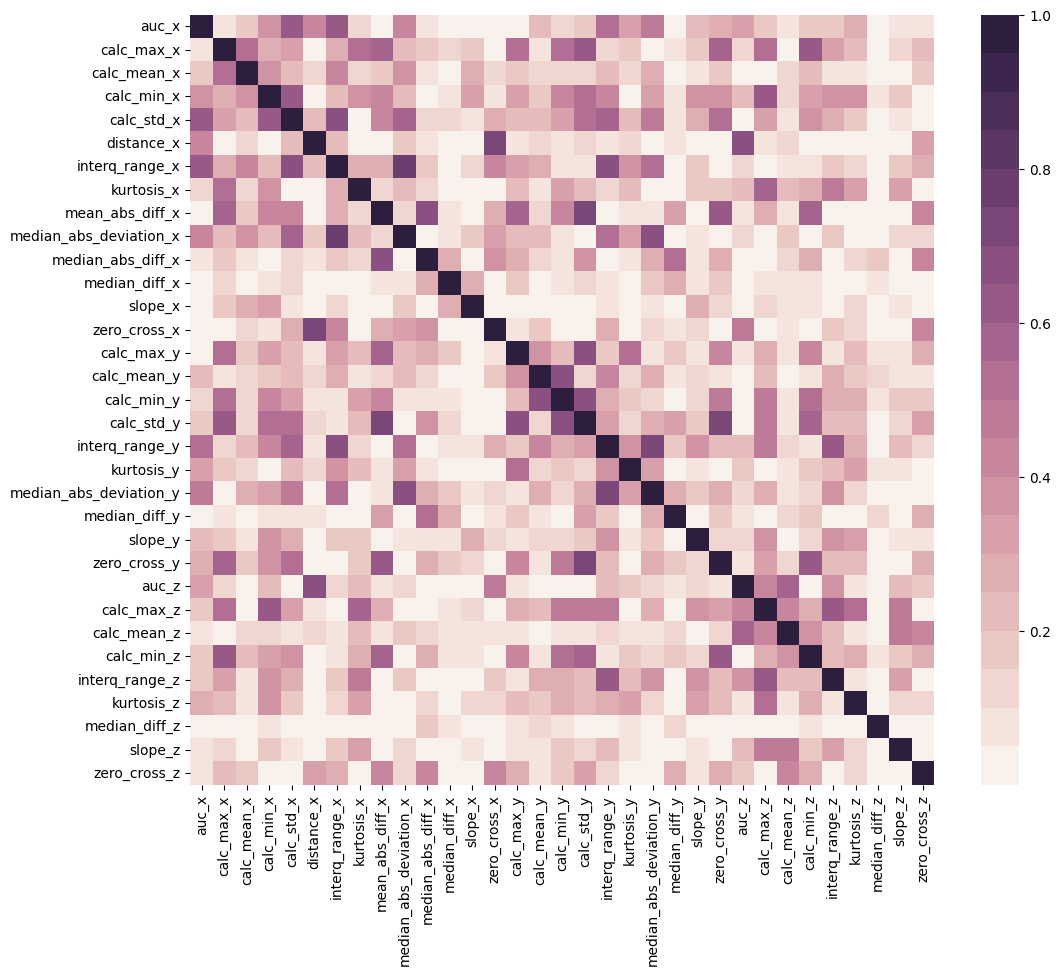

In [107]:
# Correlation plot for the remaining features
plt.figure(figsize=(12,10))
ax=sns.heatmap(abs(X_train.corr()), annot=False, cmap=sns.cubehelix_palette(20,  light=0.95, dark=0.15))
ax.xaxis.tick_top
plt.show()

In [110]:
# Import the module for the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Classification with Random Forests
classifier = RandomForestClassifier(min_samples_split=10)

activities = ['moving', 'falling', 'others']
#activities = ['moving', 'running', 'jumping','waling_down', 'walking_up', 'falling','lying','other']


# Train The Classifier
model = classifier.fit(X_train.iloc[:,:], Y_train.ravel())

# Predict Test Data
y_predict = classifier.predict(X_test.iloc[:,:])

# Get the Classification Report
accuracy = accuracy_score(Y_test, y_predict)*100
print(classification_report(Y_test, y_predict, target_names = activities))
print('Accuracy: ' + str(accuracy) + '%')


              precision    recall  f1-score   support

      moving       0.47      0.66      0.55        79
     falling       0.14      0.03      0.06        29
      others       0.29      0.23      0.26        47

    accuracy                           0.41       155
   macro avg       0.30      0.31      0.29       155
weighted avg       0.36      0.41      0.37       155

Accuracy: 41.29032258064516%


In [111]:
# Classification with KNN
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier()

activities = ['moving', 'falling', 'others']
#activities = ['moving', 'running', 'jumping','waling_down', 'walking_up', 'falling','lying','other']


# Train The Classifier
classifier.fit(X_train.iloc[:,:], Y_train.ravel())

# Predict Test Data
y_predict = classifier.predict(X_test.iloc[:,:])

# Get the Classification Report
accuracy = accuracy_score(Y_test, y_predict)*100
print(classification_report(Y_test, y_predict, target_names = activities))
print('Accuracy: ' + str(accuracy) + '%')


              precision    recall  f1-score   support

      moving       0.52      0.67      0.59        79
     falling       0.15      0.14      0.14        29
      others       0.15      0.09      0.11        47

    accuracy                           0.39       155
   macro avg       0.27      0.30      0.28       155
weighted avg       0.34      0.39      0.36       155

Accuracy: 39.35483870967742%


In [17]:
# Classification with Naive Bayes
from sklearn.naive_bayes import GaussianNB 
classifier = GaussianNB()

activities = ['moving', 'falling', 'others']
#activities = ['moving', 'running', 'jumping','waling_down', 'walking_up', 'falling','lying','other']


# Train The Classifier
classifier.fit(X_train.iloc[:,:], Y_train.ravel())

# Predict Test Data
y_predict = classifier.predict(X_test.iloc[:,:])

# Get the Classification Report
accuracy = accuracy_score(Y_test, y_predict)*100
print(classification_report(Y_test, y_predict, target_names = activities))
print('Accuracy: ' + str(accuracy) + '%')


              precision    recall  f1-score   support

      moving       1.00      0.99      0.99        79
     falling       0.85      1.00      0.92        29
      others       0.98      0.89      0.93        47

    accuracy                           0.96       155
   macro avg       0.94      0.96      0.95       155
weighted avg       0.97      0.96      0.96       155

Accuracy: 96.12903225806451%


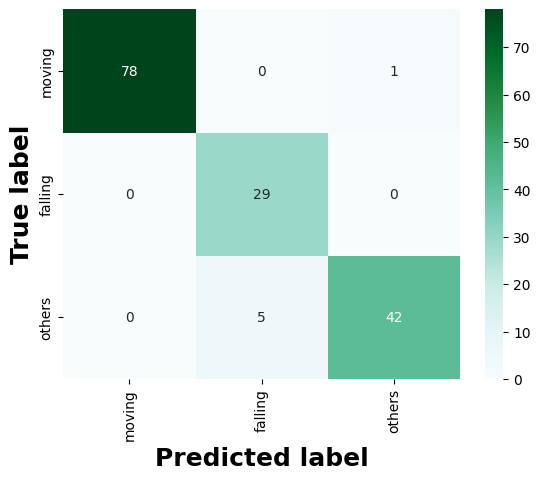

In [19]:
# Confusion Matrix
cm = confusion_matrix(Y_test, y_predict)
df_cm = pd.DataFrame(cm, index=[i for i in activities], columns = [i for i in activities])
plt.figure()
ax = sns.heatmap(df_cm, cbar = True, cmap="BuGn", annot = True, fmt = 'd')
plt.setp(ax.get_xticklabels(), rotation = 90)
plt.ylabel('True label', fontweight = 'bold', fontsize = 18)
plt.xlabel('Predicted label', fontweight = 'bold', fontsize = 18)
plt.show()